In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import os
import PySimpleGUI as sg

In [12]:
HSV_RANGES = {
    'red': [
        {
            'lower': np.array([154, 209, 106]),
            'upper': np.array([194, 249, 206])
        },
    ],
    'white': [
        {
            'lower': np.array([6, 0, 145]),
            'upper': np.array([46, 40, 245])
        }
    ]
}
print(HSV_RANGES['red'][0]['lower'][0])

154


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import PySimpleGUI as sg
import matplotlib
matplotlib.use('TkAgg')

def draw_figure(figure_canvas_agg, loc=(0, 0)):
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)

def create_mask(hsv_img, colors):
    mask = np.zeros((hsv_img.shape[0], hsv_img.shape[1]), dtype=np.uint8)

    for color in colors:
        for color_range in HSV_RANGES[color]:
            mask += cv2.inRange(
                hsv_img,
                color_range['lower'],
                color_range['upper']
            )

    return mask

fig = plt.gcf()      # if using Pyplot then get the figure from the 
fig.set_size_inches(12,6)
figure_x, figure_y, figure_w, figure_h = fig.bbox.bounds
plt.show()
axs = fig.add_subplot(321)

# fig, axs = plt.add_subplot(3, 2, figsize=(18,18))
# figure_x, figure_y, figure_w, figure_h = fig.bbox.bounds
# plt.show()

def get_pixel_count(path, fig, axs, save_files=False):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_mask = create_mask(img_hsv, ['red'])
    mask_img = cv2.bitwise_and(img_hsv, img_hsv, mask=red_mask)
    gray_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    red_pixel_area = cv2.countNonZero(gray_img)    
    
    white_mask = create_mask(img_hsv, ['white'])
    white_mask_img = cv2.bitwise_and(img_hsv, img_hsv, mask=white_mask)
    white_mask_img_gray = cv2.cvtColor(white_mask_img, cv2.COLOR_BGR2GRAY)
    non_tissue_area = cv2.countNonZero(white_mask_img_gray)
    total_area = gray_img.shape[0] * gray_img.shape[1]
    percentage = red_pixel_area / (total_area - non_tissue_area)
    print(f"RED PIXELS: {red_pixel_area}")
    print(f"NON-TISSUE PIXELS: {non_tissue_area}")
    print(f"TOTAL PIXELS: {total_area}")
    print(f"PERCENT RED: {percentage}")
    fig.clear()
#     fig, axs = plt.subplots(3, 2, figsize=(18,18))
    fig.suptitle(f"Image: {path}", fontsize=14, fontweight='bold')
    fig.text(0.05, 0.05,
            f"TOTAL PIXELS: {total_area}; RED PIXELS: {red_pixel_area}; NON-TISSUE PIXELS: {non_tissue_area}; PERCENT RED: {percentage:f}",
            fontsize=10)
    
    plt.subplot(231)
    plt.imshow(rgb_img)
#     plt.set_title("Original image")
    plt.subplot(232)
    plt.imshow(img_hsv)
#     plt.set_title("HSV image")
    plt.subplot(233)
    plt.imshow(mask_img)
#     plt.set_title("HSV image with red mask")
    plt.subplot(234)
    plt.imshow(gray_img, cmap='gray')
#     plt.set_title("Converted image for pixel count")
    plt.subplot(235)
    plt.imshow(white_mask_img)
#     plt.set_title("Non-tissue mask")
    plt.subplot(236)
    plt.imshow(white_mask_img_gray, cmap='gray')

    
    if save_files:
        plt.savefig(f"{path}_plot.png")
    
    return (img_hsv,
        mask_img,
        gray_img,
        white_mask_img,
        white_mask_img_gray)

# fig = plt.gcf()      # if using Pyplot then get the figure from the plot
# figure_x, figure_y, figure_w, figure_h = fig.bbox.bounds
# plt.show()
# ax = fig.add_subplot(111)

HSV_RANGES = {
    'red': [
        {
            'lower': np.array([154, 118, 106]),
            'upper': np.array([194, 249, 206])
        },
    ],
    'white': [
        {
            'lower': np.array([6, 0, 145]),
            'upper': np.array([46, 40, 245])
        }
    ]
}

sg.change_look_and_feel('DarkAmber')

layout = [  [sg.Slider(range=(0, 255), default_value=HSV_RANGES['red'][0]['lower'][0], resolution=1, orientation="h"),sg.Slider(range=(0, 255), default_value=HSV_RANGES['red'][0]['upper'][0], resolution=1, orientation="h")],
            [sg.Slider(range=(0, 255), default_value=HSV_RANGES['red'][0]['lower'][1], resolution=1, orientation="h"),sg.Slider(range=(0, 255), default_value=HSV_RANGES['red'][0]['upper'][1], resolution=1, orientation="h")],
            [sg.Slider(range=(0, 255), default_value=HSV_RANGES['red'][0]['lower'][2], resolution=1, orientation="h"),sg.Slider(range=(0, 255), default_value=HSV_RANGES['red'][0]['upper'][2], resolution=1, orientation="h")],
            [sg.Canvas(size=(figure_w, figure_h), key='canvas')],
            [sg.Button('Ok'), sg.Button('Cancel')] ]


# Create the Window
window = sg.Window('Picker', layout)
window.Finalize()
canvas_elem = window['canvas']
graph = FigureCanvasTkAgg(fig, master=canvas_elem.TKCanvas)
canvas = canvas_elem.TKCanvas
currentVals = None

figure_canvas_agg = FigureCanvasTkAgg(fig, canvas)

while True:
    event, values = window.read(timeout=100)
    
    if event in (None, 'Cancel'):   # if user closes window or clicks cancel
        break
    if currentVals != values:
        canvas.delete("all")
        get_pixel_count("./AC3-14day-7.tif", fig, axs)
        print(values)
        HSV_RANGES = {
            'red': [
                {
                    'lower': np.array([values[0], values[2], values[4]]),
                    'upper': np.array([values[1], values[3], values[5]])
                },
            ],
            'white': [
                {
                    'lower': np.array([6, 0, 145]),
                    'upper': np.array([46, 40, 245])
                }
            ]
        }
        
        draw_figure(figure_canvas_agg)
    currentVals = values

window.close()

RED PIXELS: 71406
NON-TISSUE PIXELS: 337358
TOTAL PIXELS: 1392640
PERCENT RED: 0.06766532547698151
{0: 154.0, 1: 194.0, 2: 118.0, 3: 249.0, 4: 106.0, 5: 206.0, 'canvas': None}


In [2]:
def show_img(img):
    fig, ax = plt.subplots(figsize=(12, 15))
    ax.imshow(img)

In [43]:
path = ""
img_name = "test.png"
cv2.imwrite(f"./{path}/{img_name}", cv2.cvtColor(img_hsv, cv2.COLOR_BGR2RGB))

True

In [1]:
## https://stackoverflow.com/questions/50221851/cant-make-yellow-disappear-with-hsv-opencv-python
def create_mask(hsv_img, colors):
    """
    Creates a binary mask from HSV image using given colors.
    """
    # noinspection PyUnresolvedReferences
    mask = np.zeros((hsv_img.shape[0], hsv_img.shape[1]), dtype=np.uint8)

    for color in colors:
        for color_range in HSV_RANGES[color]:
            # noinspection PyUnresolvedReferences
            mask += cv2.inRange(
                hsv_img,
                color_range['lower'],
                color_range['upper']
            )

    return mask

HSV_RANGES = {
    # red is a major color
    'red': [
#         [  1  88 122] [ 41 128 222]
        # [ -4  92 112] [ 36 132 212]
#         [ -7  34 112] [ 33  74 212]
        # [  5 -10 106] [ 45  30 206]
        #[ -6  86 111] [ 34 126 211]
        # [155  42 135] [195  82 235]
        # [-13  16 128] [ 27  56 228]
        #[  5 -11 117] [ 45  29 217]
        #[157 215 100] [197 255 200]
        # [154 209 106] [194 249 206]
        {
            'lower': np.array([154, 209, 106]),
            'upper': np.array([194, 249, 206])
        },
        {
            'lower': np.array([157, 215, 100]),
            'upper': np.array([197, 255, 200])
        },
#         {
#             'lower': np.array([0, 39, 64]),
#             'upper': np.array([20, 255, 255])
#         },
#         {
#             'lower': np.array([161, 39, 64]),
#             'upper': np.array([180, 255, 255])
#         }
    ],
    # yellow is a minor color
    'yellow': [
        {
            'lower': np.array([21, 39, 64]),
            'upper': np.array([40, 255, 255])
        }
    ],
    # green is a major color
    'green': [
        {
            'lower': np.array([41, 39, 64]),
            'upper': np.array([80, 255, 255])
        }
    ],
    # cyan is a minor color
    'cyan': [
        {
            'lower': np.array([81, 39, 64]),
            'upper': np.array([100, 255, 255])
        }
    ],
    # blue is a major color
    'blue': [
        {
            'lower': np.array([101, 39, 64]),
            'upper': np.array([140, 255, 255])
        }
    ],
    # violet is a minor color
    'violet': [
        {
            'lower': np.array([141, 39, 64]),
            'upper': np.array([160, 255, 255])
        }
    ],
    # next are the monochrome ranges
    # black is all H & S values, but only the lower 25% of V
    'black': [
        {
            'lower': np.array([0, 0, 0]),
            'upper': np.array([180, 255, 63])
        }
    ],
    # gray is all H values, lower 15% of S, & between 26-89% of V
    'gray': [
        {
            'lower': np.array([0, 0, 64]),
            'upper': np.array([180, 38, 228])
        }
    ],
    # white is all H values, lower 15% of S, & upper 10% of V
    'white': [
        {
            'lower': np.array([6, 0, 145]),
            'upper': np.array([46, 40, 245])
        }
    ]
}

NameError: name 'np' is not defined

RED PIXELS: 47005
NON-TISSUE PIXELS: 138547
TOTAL PIXELS: 1392640
PERCENT RED: 0.03748127132517286


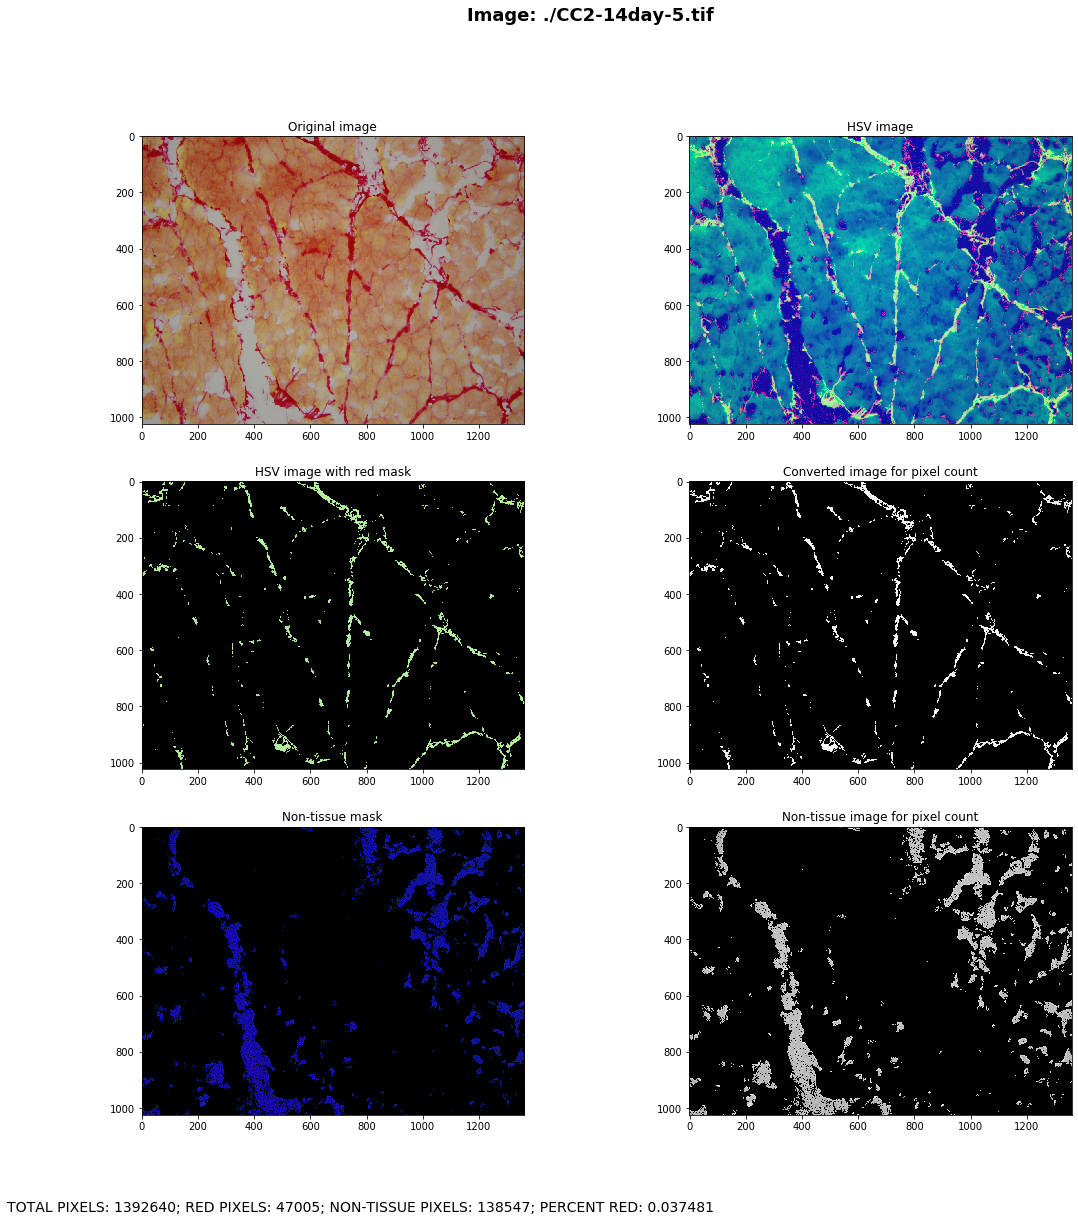

In [47]:
img_hsv, mask_img, gray_img, white_mask_img, white_mask_img_gray = get_pixel_count("./CC2-14day-5.tif")

In [11]:
df = pd.DataFrame(columns=['filename', 'red_pixel_count', 'non_tissue_pixel_count','total_pixel_count', 'percent_red'])

In [19]:
df.loc[0]= ['test', 10, 20, 30,.33]

In [20]:
display(df)

,filename,red_pixel_count,non_tissue_pixel_count,total_pixel_count,percent_red
0,test,10,20,30,0.33


In [13]:
# "./AC#4 (left-1).tif"
def get_pixel_count(path, save_files=False):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_mask = create_mask(img_hsv, ['red'])
    mask_img = cv2.bitwise_and(img_hsv, img_hsv, mask=red_mask)
    gray_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    red_pixel_area = cv2.countNonZero(gray_img)    
    
    white_mask = create_mask(img_hsv, ['white'])
    white_mask_img = cv2.bitwise_and(img_hsv, img_hsv, mask=white_mask)
    white_mask_img_gray = cv2.cvtColor(white_mask_img, cv2.COLOR_BGR2GRAY)
    non_tissue_area = cv2.countNonZero(white_mask_img_gray)
    total_area = gray_img.shape[0] * gray_img.shape[1]
    percentage = red_pixel_area / (total_area - non_tissue_area)
    print(f"RED PIXELS: {red_pixel_area}")
    print(f"NON-TISSUE PIXELS: {non_tissue_area}")
    print(f"TOTAL PIXELS: {total_area}")
    print(f"PERCENT RED: {percentage}")
    
    fig, axs = plt.subplots(3, 2, figsize=(18,18))
    fig.suptitle(f"Image: {path}", fontsize=18, fontweight='bold')
    fig.text(0.05, 0.05,
            f"TOTAL PIXELS: {total_area}; RED PIXELS: {red_pixel_area}; NON-TISSUE PIXELS: {non_tissue_area}; PERCENT RED: {percentage:f}",
            fontsize=14)
    axs[0, 0].imshow(rgb_img)
    axs[0, 0].set_title("Original image")
    axs[0, 1].imshow(img_hsv)
    axs[0, 1].set_title("HSV image")
    axs[1, 0].imshow(mask_img)
    axs[1, 0].set_title("HSV image with red mask")
    axs[1, 1].imshow(gray_img, cmap='gray')
    axs[1, 1].set_title("Converted image for pixel count")
    axs[2, 0].imshow(white_mask_img)
    axs[2, 0].set_title("Non-tissue mask")
    axs[2, 1].imshow(white_mask_img_gray, cmap='gray')
    axs[2, 1].set_title("Non-tissue image for pixel count")
    
    if save_files:
        plt.savefig(f"{path}_plot.png")
    
    return (img_hsv,
        mask_img,
        gray_img,
        white_mask_img,
        white_mask_img_gray)

In [14]:
path, red_pixel_area, non_tissue_area, total_area, percentage = get_pixel_count("./AC#2 (left-1).tif", True)

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [62]:
path = ""
img_name = "test.png"
# cv2.imwrite(f"./{path}/{img_name}", cv2.cvtColor(white_mask_img_gray, cv2.COLOR_GRAY2BGR))
cv2.imwrite(f"./{path}/{img_name}", gray_img)
# plt.imshow(img_hsv,  aspect='auto')

True

RED PIXELS: 118715
NON-TISSUE PIXELS: 480705
TOTAL PIXELS: 1392640
PERCENT RED: 0.13017923426560007


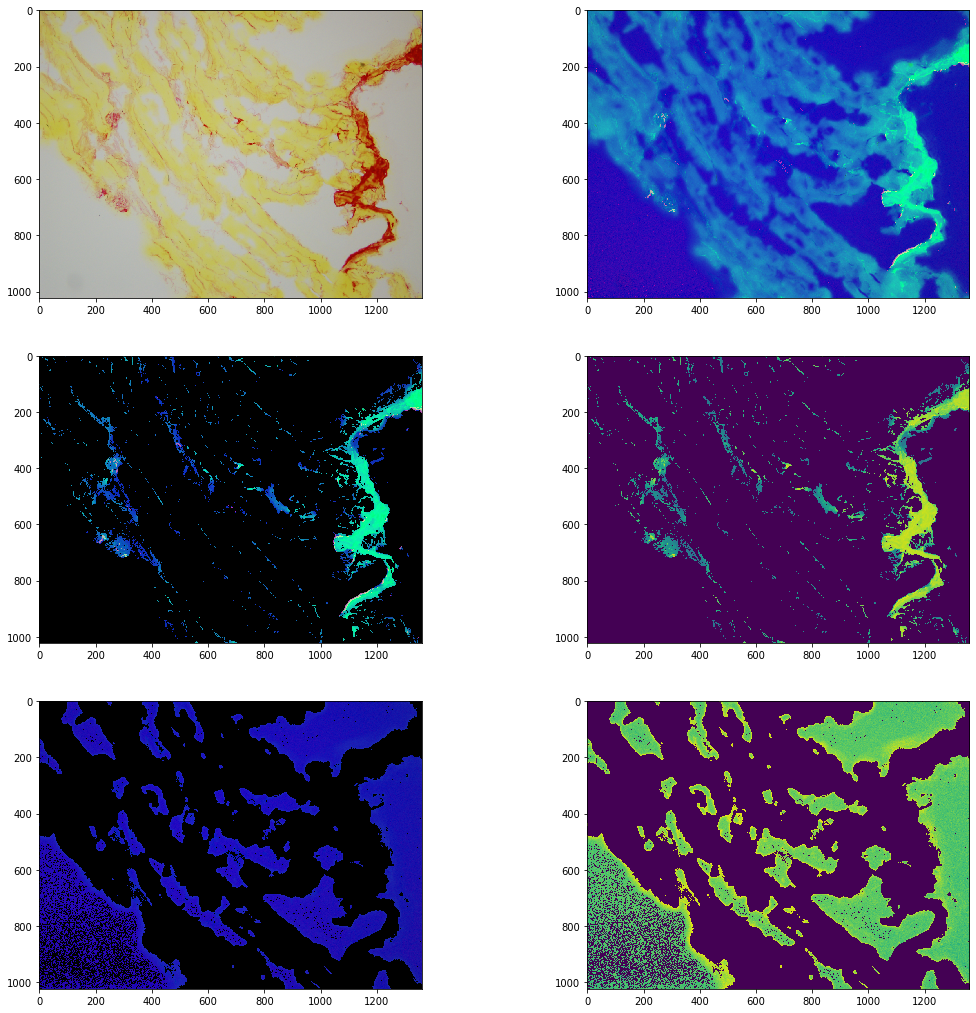

In [66]:
img_hsv = get_pixel_count("./CC2 (rightdown-2).tif")

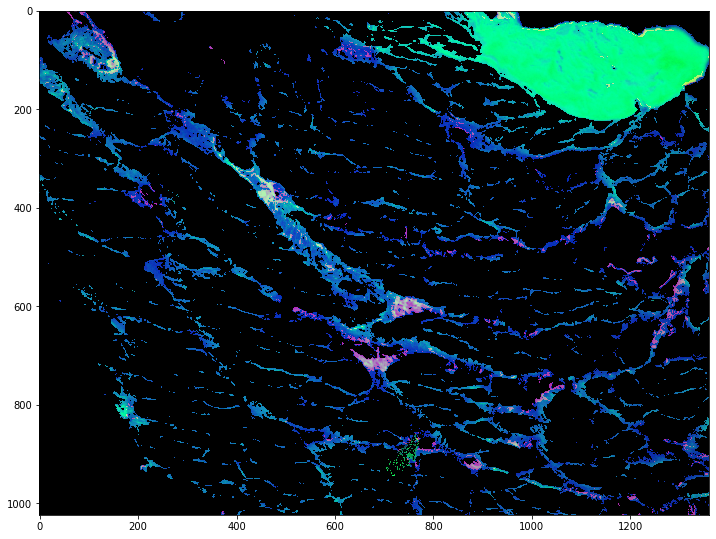

In [19]:
red_mask = create_mask(img_hsv, ['red'])
mask_img = cv2.bitwise_and(img_hsv, img_hsv, mask=red_mask)
show_img(mask_img)

In [ ]:
# gray_image = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
# show_img(gray_image)
# nonzero = cv2.countNonZero(gray_image)

# print(nonzero, nonzero/(gray_image.shape[0] * gray_image.shape[1]))

In [118]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("./") if f.endswith(".tif")]
# print(onlyfiles)

In [10]:
import numpy as np

def pca_color_augmentation_numpy(image_array_input):
    assert image_array_input.ndim == 3 and image_array_input.shape[2] == 3
    assert image_array_input.dtype == np.uint8

    img = image_array_input.reshape(-1, 3).astype(np.float32)
    scaling_factor = np.sqrt(3.0 / np.sum(np.var(img, axis=0)))
    img *= scaling_factor

    cov = np.cov(img, rowvar=False)
    U, S, V = np.linalg.svd(cov)

    rand = np.random.randn(3) * 0.1
    delta = np.dot(U, rand*S)
    delta = (delta * 255.0).astype(np.int32)[np.newaxis, np.newaxis, :]

    img_out = np.clip(image_array_input + delta, 0, 255).astype(np.uint8)
    return img_out

# from keras.datasets import cifar10
# import matplotlib.pyplot as plt

def demo_numpy(X):
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
    for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        aug = pca_color_augmentation_numpy(X[i])
        ax.imshow(aug)
        ax.axis("off")
    plt.show()